In [4]:
import torch

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# If CUDA is available, print additional info
if torch.cuda.is_available():
    print("CUDA device name:", torch.cuda.get_device_name(0))
    print("CUDA device count:", torch.cuda.device_count())

CUDA available: True
CUDA device name: NVIDIA GeForce RTX 3070 Laptop GPU
CUDA device count: 1


### Dataset

In [5]:
# Load data from Hugging Face
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]
# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

### Text Clustering
1. Convert the input documents to embeddings with an embedding model.
2. Reduce the dimensionality of embeddings with a dimensionality reduction model.
3. Find groups of semantically similar documents with a cluster model.

#### Embed Documents


In [6]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)



Batches: 100%|██████████| 1405/1405 [02:34<00:00,  9.07it/s]


In [7]:
embeddings.shape

(44949, 384)

### Dimensionality reduction
Dimensionality reduction allows data in high-dimensional space to be compressed to a lower-dimensional representation.

Well-known methods for dimensionality reduction are Principal Component Analysis (PCA)1 and Uniform Manifold Approximation and Projection (UMAP).

1) UMAP tends to handle nonlinear relationships and structures a bit better than PCA.


In [10]:
from umap import UMAP

# We reduce the input embeddings from 384 dimensions to 5 dimensions
umap_model = UMAP(
    n_components=5, 
    min_dist=0.0, 
    metric='cosine', 
)
reduced_embeddings = umap_model.fit_transform(embeddings)

/home/proxi/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#### Clustering

In [ ]:
from hdbscan import HDBSCAN # a density-based algorithm freely calculates the number of clusters and does not force all data points to be part of a cluster
# We fit the model and extract the clusters

hdbscan_model = HDBSCAN(
min_cluster_size=50, metric="euclidean", cluster_selection_method="eom", 
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

/home/proxi/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/proxi/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork

In [12]:
# How many clusters did we generate?
len(set(clusters))

158

In [13]:
import numpy as np

# Print first three documents in cluster 0
cluster = 3
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")

  A computer model of "a sense of humour" suggested previously
[arXiv:0711.2058,0711.2061], relating the humorous effect with a specific
malfunction in information processing, is given in somewhat different
exposition. Psychological aspects of humour are elaborated more thoroughly. The
mechanism of ... 

  Computer model of a "sense of humour" suggested previously [arXiv:0711.2058,
0711.2061, 0711.2270] is raised to the level of a realistic algorithm.
... 

  The New Yorker publishes a weekly captionless cartoon. More than 5,000
readers submit captions for it. The editors select three of them and ask the
readers to pick the funniest one. We describe an experiment that compares a
dozen automatic methods for selecting the funniest caption. We show that
n... 



/home/proxi/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/proxi/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


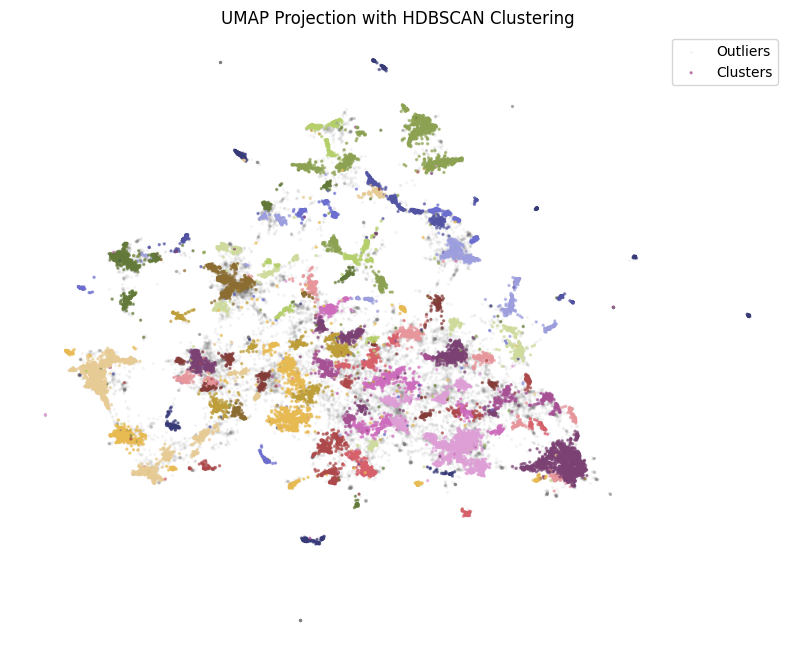

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP

# Reduce embeddings to 2D for visualization
reduced_embeddings = UMAP(
    n_components=2, 
    min_dist=0.0, 
    metric="cosine", 
    random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles  # Assuming 'titles' exists in your environment
df["cluster"] = [str(c) for c in clusters]  # Assuming 'clusters' exists

# Separate clustered points from outliers (-1 means outlier in HDBSCAN)
clustered_df = df[df["cluster"] != "-1"]
outliers_df = df[df["cluster"] == "-1"]

# Create plot
plt.figure(figsize=(10, 8))

# Plot outliers in grey
plt.scatter(
    outliers_df["x"], 
    outliers_df["y"], 
    alpha=0.05, 
    s=2, 
    c="grey",
    label="Outliers"
)

# Plot clusters with colors
plt.scatter(
    clustered_df["x"], 
    clustered_df["y"], 
    c=clustered_df["cluster"].astype(int),
    alpha=0.6, 
    s=2, 
    cmap="tab20b",
    label="Clusters"
)

plt.axis("off")
plt.title("UMAP Projection with HDBSCAN Clustering")
plt.legend()
plt.show()